# Вывод графиков для данных, полученных из KSP

## Colab

In [1]:
!git clone https://github.com/xsestech/graviton.git

Cloning into 'graviton'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 76 (delta 19), reused 63 (delta 14), pack-reused 0
Receiving objects: 100% (76/76), 1.20 MiB | 3.33 MiB/s, done.
Resolving deltas: 100% (19/19), done.


## Библиотеки

### Установка библиотек

In [2]:
!pip install matplotlib joblib numpy scipy

### Импорт

In [137]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

## Константы

In [317]:
DATA_PATH = '../data'
TIME_RANGE = 1  # В часах
N_SPLITS = 10

## Графики

## Скорость

Загрузим объекты

In [139]:
velocities = np.array(joblib.load(os.path.join(DATA_PATH, "velocities.joblib")))
cords = np.array(joblib.load(os.path.join(DATA_PATH, "cords.joblib")))
times = np.array(joblib.load(os.path.join(DATA_PATH, "time.joblib")))

In [140]:
math_v = joblib.load(os.path.join(DATA_PATH, "math_v.joblib"))
math_y = joblib.load(os.path.join(DATA_PATH, "math_y.joblib"))
math_t = joblib.load(os.path.join(DATA_PATH, "math_t.joblib"))

Найдем момент T0, и вычтем его из всего времени, переведём время в часы

In [141]:
times /= 60

In [142]:
argrange = np.argwhere((times >= 225800) & (times <= 226000))

In [143]:
velocities[argrange]

array([[5796.09695188],
       [5795.54461794],
       [5794.85493621],
       ...,
       [6199.34562771],
       [6200.50370995],
       [6201.2761899 ]])

In [144]:
times -= times[np.where(velocities == np.max(velocities[argrange]))]

In [145]:
np.max(velocities[argrange])

6761.463709415819

In [146]:
times

array([-342.575     , -342.40833333, -342.24166667, ...,  310.88333333,
        310.96666667,  311.06666667])

Найдем все индексы, которые входят во временной диапазон

In [147]:
index_in_time_range = np.argwhere(np.abs(times) <= TIME_RANGE * 60)

Переведем скорость в км/с

In [148]:
velocities /= 1000

Получим график

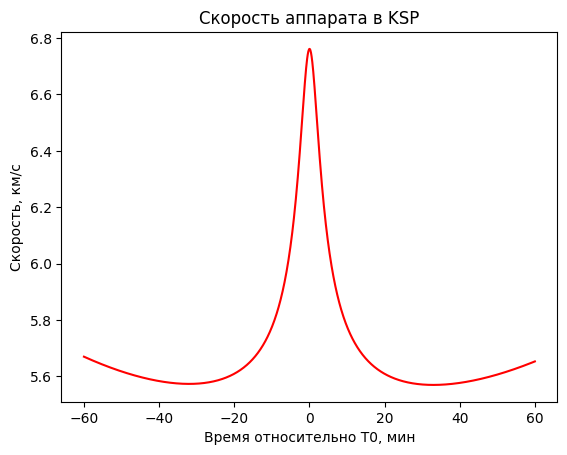

In [149]:
plt.plot(times[index_in_time_range], velocities[index_in_time_range], 'r')
plt.title("Скорость аппарата в KSP")
plt.ylabel("Скорость, км/с")
plt.xlabel("Время относительно T0, мин")
plt.show()

### Сравнительный график

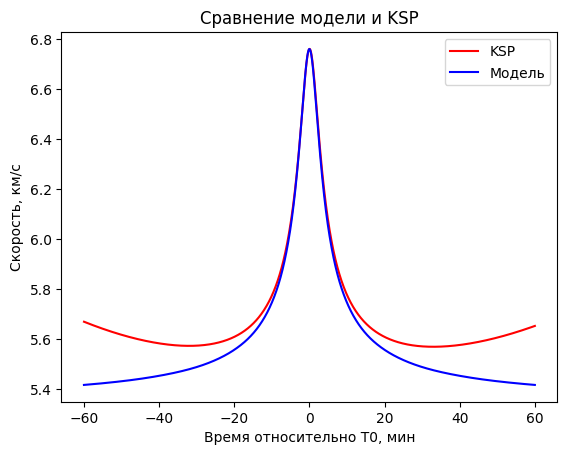

In [324]:
plt.plot(times[index_in_time_range], velocities[index_in_time_range], 'r', label='KSP')
plt.plot(math_t, math_v, 'b', label='Модель')
plt.title("Сравнение модели и KSP")
plt.ylabel("Скорость, км/с")
plt.xlabel("Время относительно T0, мин")
plt.legend(loc='best')
plt.show()

## Второй закон Кеплера

Оставляем только данные в заданном диапазоне

In [158]:
cords1 = np.squeeze(cords[index_in_time_range])
times1 = np.squeeze(times[index_in_time_range])

### Вспомогательные функции для расчетов

In [253]:
def calc_std_percent(a: np.array) -> float:
    """Расчет дисперсии в процентах от среднего"""
    return np.std(a) / np.mean(a) * 100

In [295]:
from typing import Union, Iterable, List

def find_closest_index(array: np.array, target: float) -> int:
    """
    Найти индекс ближайшего число, к заданному в массиве numpy
    :param array: массив numpy
    :param target: число, которое ищем
    :return: индекс ближайшего числа
    """
    absolute_diff = np.abs(array - target)
    closest_index = np.argmin(absolute_diff)
    return closest_index


def triangle_integrate(r: np.array, t: np.array, n_splits: int) -> Iterable[Union[List, str]]:
    """
    Проверка второго закона Кеплера на модели. Считает площадь на равных по времени промежутках, используя векторное произведение. Выводит дисперсию в процентах и строит графики выбранных промежутков
    :param r: Массив numpy координат
    :param t: Массив numpy времени измерений
    :param n_splits: Количество промежутков
    :return: Массив float c площадями за равные промежутки времени, итоговая абсолютная погрешность во времени и абсолютная погрешность по времени по каждому семплу
    """
    total_time = t[-1] - t[0]
    t = t + abs(np.min(t))
    one_sample_integration_period = (total_time) / n_splits
    n_integrated = 0
    sample_start = 0
    areas = []
    sample_error = []
    integrated_time = 0
    while n_integrated < n_splits:
        sample_end = sample_start + find_closest_index(t[sample_start:], one_sample_integration_period)
        sample_time = t[sample_start:sample_end + 1]
        current_t_sum = sample_time[-1] -  sample_time[0]
        t -= t[sample_end]
        sample_cords = r[sample_start:sample_end + 1]
        area = 0.5 * np.sum(np.linalg.norm(np.cross(sample_cords[:-1], sample_cords[1:]), axis=1))
        areas.append(area)
        n_integrated += 1
        integrated_time += current_t_sum
        sample_start = sample_end
        sample_error.append(one_sample_integration_period - current_t_sum)
        plt.plot(sample_cords[:, 0], sample_cords[:, 1])
    print(calc_std_percent(areas))
    plt.show()
    return areas, total_time - integrated_time, sample_error
        

### Расчет для KSP

57.96156458266939


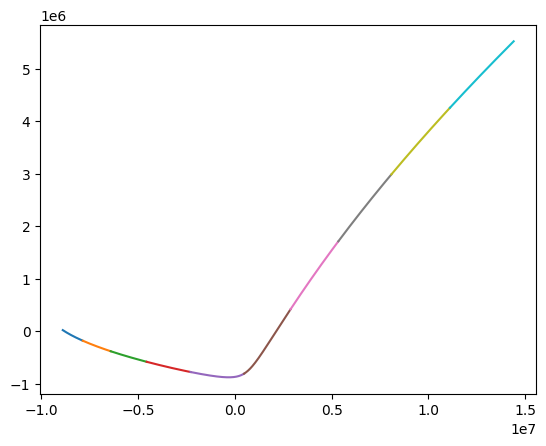

In [296]:
ares_tri_ksp, time_err_ksp, sample_error_ksp = triangle_integrate(cords1, times1, 10)

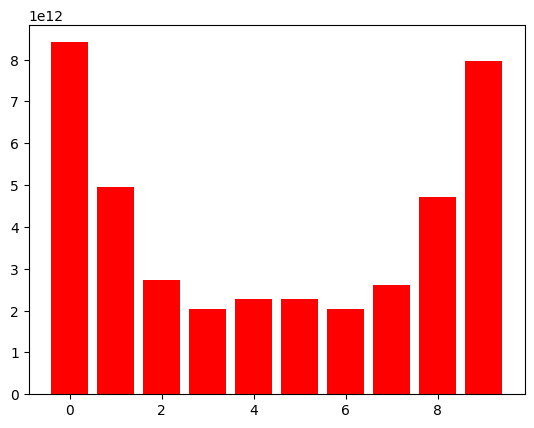

In [322]:
plt.bar(np.arange(N_SPLITS), ares_tri_ksp, color='r')
plt.show()

### Расчет для модели

0.006511523953705594


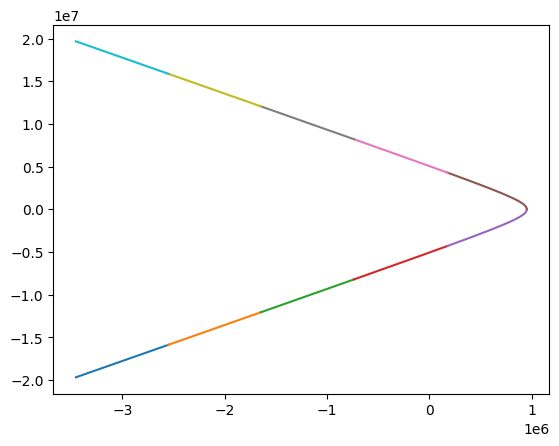

In [297]:
ares_tri_math, time_err_math, sample_error_math = triangle_integrate(math_y.T[:, 0:3], math_t, N_SPLITS)

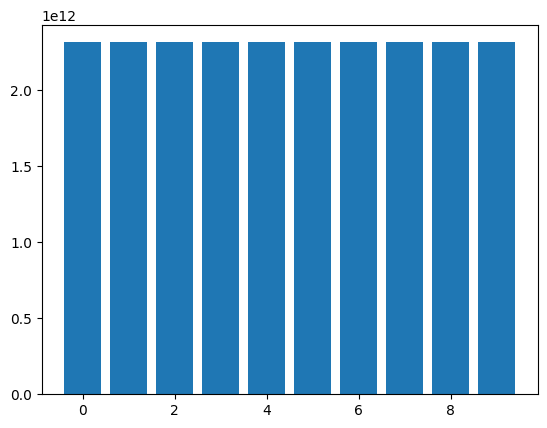

In [323]:
plt.bar(np.arange(N_SPLITS), ares_tri_math)
plt.show()